**Experimentation on Fashion Mnist with VGG16**
To demonstrate
1) Converting images with 1 channel to 3 channels
2) Resizing the images
3) Using VGG16 base model, appending with other layers and extracting features
4) Reduce learning, early stopping in callback methods

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, time
import matplotlib.pyplot as plt
#from keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split
import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten
#from keras.layers.advanced_activations import LeakyReLU
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16;
from keras.applications.vgg16 import preprocess_input
import os

Using TensorFlow backend.


In [2]:
# Read csv data files
train_data = pd.read_csv('data/fashion-mnist_train.csv')
test_data = pd.read_csv('data/fashion-mnist_test.csv')

In [3]:
train_data.shape #(60,000*785)
test_data.shape #(10000,785)
train_X= np.array(train_data.iloc[:,1:])
test_X= np.array(test_data.iloc[:,1:])
train_Y= np.array (train_data.iloc[:,0]) # (60000,)
test_Y = np.array(test_data.iloc[:,0]) #(10000,)

In [4]:
train_data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
train_X.shape, test_X.shape

((60000, 784), (10000, 784))

In [6]:
classes = np.unique(train_Y)
num_classes = len(classes)
num_classes

10

In [29]:
np.unique(train_Y)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [7]:
# Convert the images into 3 channels
train_X=np.dstack([train_X] * 3)
test_X=np.dstack([test_X]*3)
train_X.shape, test_X.shape

((60000, 784, 3), (10000, 784, 3))

In [8]:
# Reshape images as per the tensor format required by tensorflow
train_X = train_X.reshape(-1, 28,28,3)
test_X= test_X.reshape (-1,28,28,3)
train_X.shape, test_X.shape

((60000, 28, 28, 3), (10000, 28, 28, 3))

In [9]:
# Resize the images 48*48 as required by VGG16
from keras.preprocessing.image import img_to_array, array_to_img
train_X = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in train_X])
test_X = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in test_X])
#train_x = preprocess_input(x)
train_X.shape, test_X.shape

((60000, 48, 48, 3), (10000, 48, 48, 3))

In [10]:
# Normalise the data and change data type
train_X = train_X / 255.
test_X = test_X / 255.
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')

In [11]:
# Converting Labels to one hot encoded format
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

In [30]:
test_Y_one_hot

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [12]:
# Splitting train data as train and validation data
train_X,valid_X,train_label,valid_label = train_test_split(train_X,
                                                           train_Y_one_hot,
                                                           test_size=0.2,
                                                           random_state=13
                                                           )

In [13]:
# Finally check the data size whether it is as per tensorflow and VGG16 requirement
train_X.shape,valid_X.shape,train_label.shape,valid_label.shape

((48000, 48, 48, 3), (12000, 48, 48, 3), (48000, 10), (12000, 10))

In [14]:
# Define the parameters for instanitaing VGG16 model. 
IMG_WIDTH = 48
IMG_HEIGHT = 48
IMG_DEPTH = 3
BATCH_SIZE = 16

In [15]:
# Preprocessing the input 
train_X = preprocess_input(train_X)
valid_X = preprocess_input(valid_X)
test_X  = preprocess_input (test_X)

In [16]:
#  Create base model of VGG16
conv_base = VGG16(weights='vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
                  include_top=False, 
                  input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH)
                 )
conv_base.summary()


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0    

In [17]:
# Extracting features
train_features = conv_base.predict(np.array(train_X), batch_size=BATCH_SIZE, verbose=1)
test_features = conv_base.predict(np.array(test_X), batch_size=BATCH_SIZE, verbose=1)
val_features = conv_base.predict(np.array(valid_X), batch_size=BATCH_SIZE, verbose=1)
#for layer in conv_base.layers:
#    layer.trainable = False


12000/12000 [==============================] - 190s 16ms/step


In [18]:
# 6.1 Saving the features so that they can be used for future
np.savez("train_features", train_features, train_label)
np.savez("test_features", test_features, test_Y)
np.savez("val_features", val_features, valid_label)

In [19]:
# Current shape of features
print(train_features.shape, "\n",  test_features.shape, "\n", val_features.shape)

(48000, 1, 1, 512) 
 (10000, 1, 1, 512) 
 (12000, 1, 1, 512)


In [20]:
# Flatten extracted features
train_features_flat = np.reshape(train_features, (48000, 1*1*512))
test_features_flat = np.reshape(test_features, (10000, 1*1*512))
val_features_flat = np.reshape(val_features, (12000, 1*1*512))

In [21]:
from keras import models
from keras.models import Model
from keras import layers
from keras import optimizers
from keras import callbacks
from keras.layers.advanced_activations import LeakyReLU

In [22]:
# 7.0 Define the densely connected classifier followed by leakyrelu layer and finally dense layer for the number of classes
NB_TRAIN_SAMPLES = train_features_flat.shape[0]
NB_VALIDATION_SAMPLES = val_features_flat.shape[0]
NB_EPOCHS = 100

model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_dim=(1*1*512)))
model.add(layers.LeakyReLU(alpha=0.1))
model.add(layers.Dense(num_classes, activation='softmax'))

In [23]:
# Compile the model.
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(),
  # optimizer=optimizers.RMSprop(lr=2e-5),
    metrics=['acc'])

In [24]:
# Incorporating reduced learning and early stopping for callback
reduce_learning = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    verbose=1,
    mode='auto',
    epsilon=0.0001,
    cooldown=2,
    min_lr=0)

eary_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=7,
    verbose=1,
    mode='auto')

callbacks = [reduce_learning, eary_stopping]

In [25]:
# Train the the model
history = model.fit(
    train_features_flat,
    train_label,
    epochs=NB_EPOCHS,
    validation_data=(val_features_flat, valid_label),
    callbacks=callbacks
)

Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 [==============================] - 16s 330us/step - loss: 1.4826 - acc: 0.4536 - val_loss: 1.2506 - val_acc: 0.5108
Epoch 2/100
48000/48000 [==============================] - 16s 336us/step - loss: 1.1033 - acc: 0.5943 - val_loss: 1.0457 - val_acc: 0.6108
Epoch 3/100
48000/48000 [==============================] - 16s 342us/step - loss: 0.9840 - acc: 0.6397 - val_loss: 0.9367 - val_acc: 0.6611
Epoch 4/100
48000/48000 [==============================] - 17s 357us/step - loss: 0.9435 - acc: 0.6546 - val_loss: 0.9655 - val_acc: 0.6468
Epoch 5/100
48000/48000 [==============================] - 17s 364us/step - loss: 0.9087 - acc: 0.6671 - val_loss: 0.8769 - val_acc: 0.6909
Epoch 6/100
48000/48000 [==============================] - 17s 351us/step - loss: 0.8874 - acc: 0.6760 - val_loss: 0.8781 - val_acc: 0.6903
Epoch 7/100
48000/48000 [==============================] - 16s 343us/step - loss: 0.8699 - acc: 0.6805 - val_l

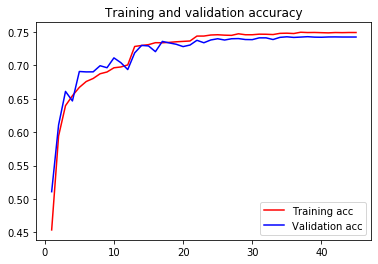

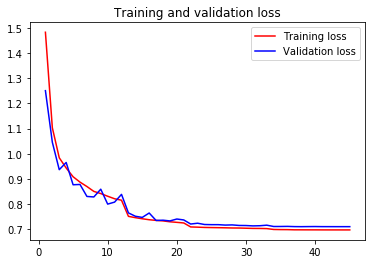

In [26]:
# plot the loss and accuracy

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()


References
https://www.kaggle.com/crawford/diagnose-lung-disease-with-vgg16
https://www.programcreek.com/python/example/92213/keras.applications.vgg16.VGG16
http://www.socouldanyone.com/2013/03/converting-grayscale-to-rgb-with-numpy.html